This notebook is written for benchmarking and prototyping the Split-Step Method

Test cases:
1. Dispersion only propagation
2. Soliton in $\chi_{3}$-system
3. Simulton in $\chi_{2}$-system

In [1]:
using BenchmarkTools, TimerOutputs
using CSV, DataFrames, JSON, JLD, OrderedCollections, NPZ
using FFTW, GLM, LinearAlgebra, Random
using LaTeXStrings, ColorSchemes, Plots
using Profile, Base.Threads, ProgressMeter
import Elliptic
import Elliptic.Jacobi
using DifferentialEquations
using Roots

In [4]:
push!(LOAD_PATH, "/home/elaksono/eo-comb/SplitStep/src/");
using Revise
using CUDA
using FileIO
using Materials
using Analytics
using Constant
using Pulse, PlotPulse, Modulation
using NLOclass, NLO
using SplitStep

In [5]:
?Analytics

search: Analytics AnalyticalProblem AbstractAnalyticalProblem



Analytics Module: Analytical OPA/OPO Solutions and Bandwidth Calculations Updated: 6 Marc 2025

This module provides a suite of functions to analyze optical parametric amplification (OPA)  and optical parametric oscillation (OPO) processes using both analytical and numerical methods. It is tailored for systems with quasi-phase matching (QPM) and includes tools for handling  both periodically poled and linearly chirped waveguides.

Key functionalities include:

1. Analytical OPA Intensity:

      * opa*cw*intensity(z, dk, opa):   Computes the intensities (signal, idler, and pump) along the propagation distance 'z'   using an analytical solution based on Jacobi elliptic functions (specifically, the "cn" function).
2. OPA ODE Solver:

      * opa*cw*ode(zvec, dk, opa):   Defines and solves the coupled ordinary differential equations (ODEs) governing the    evolution of the complex amplitudes in an OPA process. It uses DifferentialEquations.jl    for numerical integration and returns the solution in terms of amplitudes and flux.
3. CW OPO Amplitude Threshold:

      * cth*cw*opo(loss, kappa, L):   Calculates the amplitude threshold required for continuous-wave OPO operation in    periodically poled devices based on material nonlinearity and waveguide length.
4. Linearly Chirped OPA Functions:

      * dk*linear*opa(z, dω, omg*ctr, qpm*lambda, mat, phi*z*pars):   Computes the phase mismatch for a linearly chirped OPA system. The chirp is determined    by a linear variation in the poling period, characterized by the parameters (zc, dk_1).
      * solve*bw*con(omg*ctr, qpm*lambda, mat; phi*z*pars, dω0):   Solves for the gain bandwidth in frequency for a periodically poled waveguide. The bandwidth    is determined where the sinc function (arising from phase mismatch) reaches zero.
      * solve*bw*lbd*con(omg*ctr, qpm*lambda, mat; phi*z_pars, dω0, ids):   Converts the frequency bandwidth solution into wavelength terms and returns the bandwidth    along with the corresponding edge wavelengths and frequencies.
      * solve*dω*for*z(z, omg*ctr, qpm*lambda, mat, phi*z*pars; dω*guess):   Finds the frequency offset (dω) for which the phase matching condition is met at a given    propagation distance 'z' in a linearly chirped OPA setup.
      * solve*bw*linear(omg*ctr, qpm*lambda, mat, phi*z*pars):   Computes the overall gain bandwidth (in frequency) of a linearly chirped OPA by evaluating    the frequency shift between the beginning and end of the waveguide.
      * solve*bw*lbd*linear(omg*ctr, qpm*lambda, mat, phi*z*pars; ids):   Similar to solve*bw_linear, but the result is presented in terms of wavelength bandwidth    along with additional spectral details.
      * cth*cw*opo*lin(loss, kappa, dk*1):   Determines the amplitude threshold for CW OPO operation in linearly poled systems, taking    into account the chirp rate of the phase mismatch.

Dependencies:

  * Constant: Provides physical constants.
  * Elliptic and Elliptic.Jacobi: Offer computations for Jacobi elliptic functions used in the  analytical OPA solution.
  * DifferentialEquations: Supplies numerical solvers for the OPA ODEs.
  * NLOclass: Contains definitions and functions for nonlinear optical processes.
  * Materials: Supplies material properties and dispersion functions.
  * Roots: Used for root-finding in phase-matching and bandwidth calculations.

Overall, this module is designed to facilitate the analysis of nonlinear optical interactions  in engineered waveguide structures, providing both direct analytical expressions and numerical  tools to simulate and optimize OPA and OPO processes under various experimental conditions.


# Materials

In [ ]:
# Comparing different Lithium Niobate Dispersive Relation
lbd_list = collect(0.8:0.1:4.2);
omg_list = (2*pi*c0*1e-6) ./ lbd_list;

n_linbo3e_jundt_list = [n_func(linbo3_e_jundt, omg) for omg in omg_list];
n_linbo3e_gayer_list = [n_func(linbo3_e_gayer, omg) for omg in omg_list];
n_lnlt_list = [n_func(lnlt_z, omg) for omg in omg_list];
n_lnoi_list = [n_func(lnoi_z, omg) for omg in omg_list];

plot()
# plot(lbd_list, n_linbo3e_jundt_list, label = "Zelmon, et al. 1997", frame=:box, xlabel = "λ (μm)", ylabel="n")
# plot!(lbd_list, n_linbo3e_gayer_list, label = "O. Gayer, et al. 2008")
plot!(lbd_list, n_lnlt_list, label = "NTT LNLT")
# plot!(lbd_list, n_lnoi_list, label = "HCP LNOI")

# Simple test cases and benchmarking
This is to simplify the initiation of the process

## Dispersion term convention
Note:
- I checked the correspondence between the analytical expressions for Fourier Components in both time and frequency domain. We see excellent agreement up to a certain propagation length, within which the wave distribution remains within the time window.
- The problem can be overcome by increasing Tmax (the time sampling window)

<b>Split-step and Fourier Transform</b>

The split-step scheme is based on propagation in $z$. We are working in the following frame:

$z' = z, \,\, \tau = t - \beta_{a,1}z$

The electric field amplitude should be given by:

$A(z,t) = a(z,\tau(t,z))e^{i(\omega_{a}t - \beta_{a,0}z)} + c.c.$

Definition for the Fourier transform:

$a(z,\tau) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} d\omega \,\tilde{a}(z,\omega) e^{i\omega\tau}$ <br>
$\tilde{a}(z,\omega) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} d\tau \,a(z,\tau) e^{-i\omega\tau}$ <br>

The equation of motion (dispersion only) which is consistent with definition above is as follows:

$\partial_{z}a(z,\tau) = -i\beta[-i\partial_{\tau}]a(z,\tau)$

This means the time derivatives lead to the following dispersive terms:

$(-i\partial_{\tau})^{n}a(z,\tau) \rightarrow \omega^{n}\tilde{a}(z,\omega)$

<b>Discrete Fourier Transform vs Continuous Fourier Transform</b>

Julia FFTW definition for the Fourier Transform

$\overline{A}[k] = DFT(A)[k] = \sum_{n=1}^{N}exp[-i\frac{2\pi}{N}(n-1)(k-1)]A[n]$<br>
$A[n] = IDFT(\overline{A})[k] = \frac{1}{N}\sum_{k=1}^{N}exp[i\frac{2\pi}{N}(n-1)(k-1)]\overline{A}[k]$

In the DFT scheme, we need to sample N points within a time window $\Delta T$. It can be shown that the following relationship holds:

$A[n] = A(\frac{n\Delta T}{N})$ <br>
$\overline{A}[k] = \frac{\sqrt{2\pi}N}{\Delta T}.\tilde{A}\bigg(\frac{2\pi(k-1)}{\Delta T}\bigg)$

<b> Units </b>

In my current implementation, we can use the following unit

$\lambda: \mu m$, $t: ps$, $\beta^{(n)}: ps^{n} mm^{-1}$

## Dispersion test

In [32]:
lbd_p = 1.064e-6; lbd_s = 1.55e-6;
lbd_i = (lbd_p * lbd_s) / (lbd_s - lbd_p)
lbd_ctr = [lbd_p; lbd_s; lbd_i]
omg_ctr = (2*pi*c0*1e-12) ./ lbd_ctr

linbo3_e_taylor = TaylorMaterial("LiNbO3 e-pol", 1.0, omg_ctr, 2, 0.0)
convert_to_TaylorMaterial(linbo3_e_gayer, linbo3_e_taylor, omg_ctr)

In [34]:
# Pulse properties
pulse1 = pars_pulse()
pulse1.amp_max = [1.0 ; 1.0 ; 1.0];
pulse1.omg_ctr = omg_ctr;
pulse1.T_pulse = [1.0 ; 2.0 ; 0.1];
pulse1.N_div = (2^10);
pulse1.f_pulse = Pulse.ff_gauss;

# The pulsed DOPA properties
disp0 = nl_pulse(linbo3_e_taylor, pulse1; dz = 1e-2, pulse_ref = 1, delta_k = 0.0);
disp1 = nl_pulse(linbo3_e_gayer, pulse1; dz = 1e-2, pulse_ref = 1, delta_k = 0.0);

FFTW.set_num_threads(1)
fft_dim = 1
p_fft1! = plan_fft!(disp0.init_amp, fft_dim);
p_ifft1! = plan_ifft!(disp0.init_amp, fft_dim);

In [217]:
# amp_ft = zeros(ComplexF32, size(disp1.init_amp))
# amp_ft[:,1] .= fft(disp1.out_amp[:,1]) .* (disp1.dT);
# amp_ft[:,2] .= fft(disp1.out_amp[:,2]) .* (disp1.dT);

In [35]:
# Analytical solution
Lz = 3.0;
sorted_time = sort(disp1.arr_time)
sorted_id = sortperm(disp1.arr_time)

arr_omega = (2*pi) .* fftfreq(disp1.pulse.N_div) * (pulse1.N_div / (2*disp1.Tmax))
sorted_freq = sort(arr_omega) ./ (2*pi)
sorted_f_id = sortperm(arr_omega)

γf = sqrt(2*pi) * pulse1.N_div / (2 * disp1.Tmax)

# Second order dispersion only
# Frequency space
sol_pump_ft = [γf .* pulse_disp_FT(ω, Lz, pulse1, disp0.mat, 1; pulse_ref = 1) for ω in arr_omega];
sol_signal_ft = [γf .* pulse_disp_FT(ω, Lz, pulse1, disp0.mat, 2; pulse_ref = 1) for ω in arr_omega];

# Pulse in time
sol_pump = [pulse_disp(t, Lz, pulse1, disp0.mat, 1; pulse_ref = 1) for t in disp0.arr_time];
sol_signal = [pulse_disp(t, Lz, pulse1, disp0.mat, 2; pulse_ref = 1) for t in disp0.arr_time];

# Full Dispersion
# Frequency space
sol_pump_ft_fd = [γf .* pulse_disp_FT_fd(ω, Lz, pulse1, disp1.mat, 1 ; pulse_ref = 1) for ω in arr_omega];
sol_signal_ft_fd = [γf .* pulse_disp_FT_fd(ω, Lz, pulse1, disp1.mat, 2; pulse_ref = 1) for ω in arr_omega];

# Pulse in time
sol_pump_fd = ifft(sol_pump_ft_fd)[sorted_id];
sol_signal_fd = ifft(sol_signal_ft_fd)[sorted_id];

In [36]:
# Numerical solution (time)
split_step_nl!(Lz, disp0, op_nl_dopa!; step_method = rk4_step_nl!, p_fft = (p_fft1!, p_ifft1!))
split_step_nl!(Lz, disp1, op_nl_dopa!; step_method = rk4_step_nl!, p_fft = (p_fft1!, p_ifft1!))

In [37]:
# The solution in frequency space
init_pump_f = fft(disp1.init_amp[:,1])
init_signal_f = fft(disp1.init_amp[:,2])

out_pump_f0 = fft(disp0.out_amp[:,1])
out_signal_f0 = fft(disp0.out_amp[:,2])

out_pump_f1 = fft(disp1.out_amp[:,1])
out_signal_f1 = fft(disp1.out_amp[:,2]);

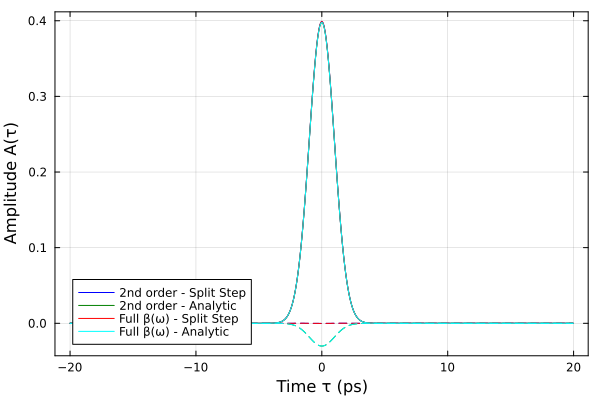

In [41]:
# Propagation in time domain
test_plot = plot(frame=:box, xlabel = "Time τ (ps)", ylabel = "Amplitude A(τ)", legend=:bottomleft)

# Initial pulse
# plot!(test_plot, sorted_time, real.(disp1.init_amp[sorted_id,1]), color=:gray, label = "Initial pulse")
# plot!(test_plot, sorted_time, imag.(disp1.init_amp[sorted_id,1]), color=:gray, line=:dash, label=:none)

# Propagated pulse with second-order dispersion
plot!(test_plot, sorted_time, real.(disp0.out_amp[sorted_id,1]), color=:blue, label = "2nd order - Split Step")
plot!(test_plot, sorted_time, imag.(disp0.out_amp[sorted_id,1]), color=:blue, line=:dash, label=:none)

plot!(test_plot, sorted_time, real.(sol_pump[sorted_id]), color=:green, label = "2nd order - Analytic")
plot!(test_plot, sorted_time, imag.(sol_pump[sorted_id]), color=:green, line=:dash, label=:none)

# Propagated pulse with full dispersion 
plot!(test_plot, sorted_time, real.(disp1.out_amp[sorted_id,1]), color=:red, label = "Full β(ω) - Split Step")
plot!(test_plot, sorted_time, imag.(disp1.out_amp[sorted_id,1]), color=:red, line=:dash, label=:none)

plot!(test_plot, sorted_time, real.(sol_pump_fd), color=:cyan, label = "Full β(ω) - Analytic")
plot!(test_plot, sorted_time, imag.(sol_pump_fd), color=:cyan, line=:dash, label=:none)

savefig("./figures/disp_time_plot.png")
test_plot

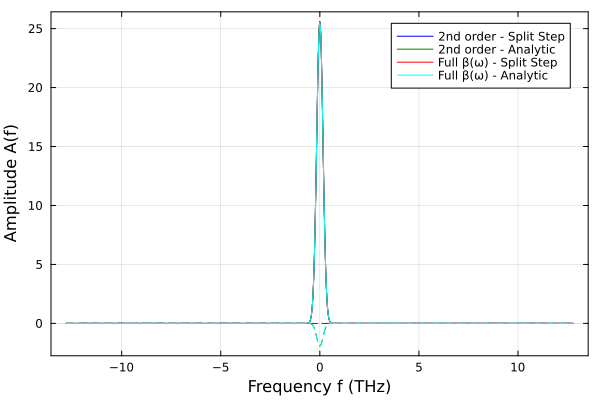

In [42]:
# Propagation in frequency domain
test_plot_2 = plot(frame=:box, xlabel = "Frequency f (THz)", ylabel = "Amplitude A(f)")

# Propagated pulse with second-order dispersion
plot!(test_plot_2, sorted_freq, real.(out_pump_f0[sorted_f_id]), color=:blue, label = "2nd order - Split Step")
plot!(test_plot_2, sorted_freq, imag.(out_pump_f0[sorted_f_id]), color=:blue, line=:dash, label=:none)

plot!(test_plot_2, sorted_freq, real.(sol_pump_ft[sorted_f_id]), color=:green, label = "2nd order - Analytic")
plot!(test_plot_2, sorted_freq, imag.(sol_pump_ft[sorted_f_id]), color=:green, line=:dash, label=:none)

# Propagated pulse with full dispersion 
plot!(test_plot_2, sorted_freq, real.(out_pump_f1[sorted_f_id]), color=:red, label = "Full β(ω) - Split Step")
plot!(test_plot_2, sorted_freq, imag.(out_pump_f1[sorted_f_id]), color=:red, line=:dash, label=:none)

plot!(test_plot_2, sorted_freq, real.(sol_pump_ft_fd[sorted_f_id]), color=:cyan, label = "Full β(ω) - Analytic")
plot!(test_plot_2, sorted_freq, imag.(sol_pump_ft_fd[sorted_f_id]), color=:cyan, line=:dash, label=:none)

savefig("./figures/disp_freq_plot.png")
test_plot_2

## Simulton in $\chi_{2}$ system
Test case if the dispersion term interacts correctly with the nonlinear term

In [27]:
sml_ωctr = [500.0, 1000.0];
sml_taylor = TaylorMaterial("Simulton Taylor Material", 1.0, sml_ωctr, 2, 3.93e-2);

sml_taylor.beta_array = [0.0     0.0;
                         0.0     0.0;
                         1.75e-3 3.5e-3];

In [29]:
# Pulse properties
pulse_sml1 = pars_pulse()

# Specific for simulton
Amax = 1.2
T_sml1 = sqrt(6 * abs(sml_taylor.beta_array[3,1]) / (sml_taylor.kappa * Amax))

pulse_sml1.amp_max = [Amax ; 0.5 * 1im * Amax];
pulse_sml1.omg_ctr = sml_ωctr;
pulse_sml1.T_pulse = [T_sml1 ; T_sml1];
pulse_sml1.N_div = (2^10);
pulse_sml1.f_pulse = Pulse.ff_sech;

# The pulsed DOPA properties
sml1 = nl_pulse(sml_taylor, pulse_sml1; fac = 10, calculate_dk = false, delta_k = 0.0);

FFTW.set_num_threads(1)
p_fft1! = plan_fft!(sml1.init_amp, 1);
p_ifft1! = plan_ifft!(sml1.init_amp, 1);

In [30]:
# Split-step simulation for simulton
Lz = 30.0;
split_step_nl!(Lz, sml1, op_nl_dopa!, step_method = rk4_step_nl!, p_fft = (p_fft1!, p_ifft1!))

# Analytical result for simulton
anl_sml1 = Pulse.simulton_pulse_2(sml1.arr_time, Lz, Amax, sml_taylor.kappa, sml_taylor.beta_array[3,1]);

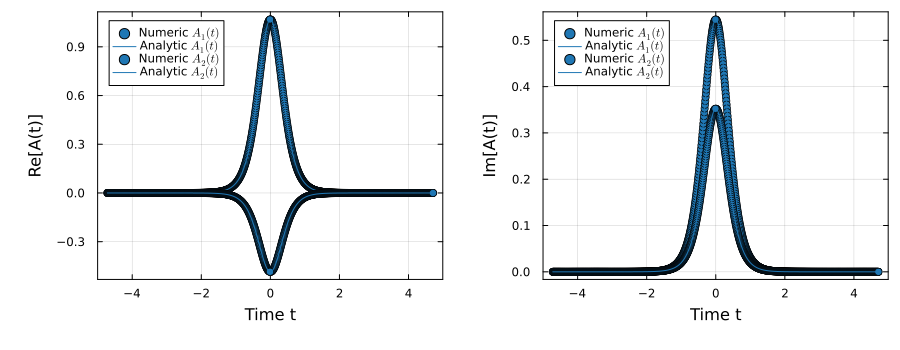

In [31]:
re_sml1_plt = plot(frame=:box); im_sml1_plt = plot(frame=:box)

plotCompare(sml1.arr_time, sml1.out_amp, anl_sml1, re_sml1_plt, margins = 2Plots.mm, legend=:topleft)
plotCompare(sml1.arr_time, sml1.out_amp, anl_sml1, im_sml1_plt; legend=:topleft, margins = 2Plots.mm,
    comp = imag, ylabel = "Im[A(t)]")

sml1_plt = plot(re_sml1_plt, im_sml1_plt, size=(900,350))
savefig("./figures/simulton_plot.png")
sml1_plt

## Adiabatic OPA 

In [14]:
lbd_p = 1.0e-6; lbd_s = 1.5e-6;
lbd_i = (lbd_p * lbd_s) / (lbd_s - lbd_p)
lbd_ctr = [lbd_s; lbd_i; lbd_p]
omg_ctr = (2*pi*c0*1e-12) ./ lbd_ctr

# LiNbO3 with zero GVD
linbo3_e_gvd0 = TaylorMaterial("LiNbO3 e-pol", 1.0, omg_ctr, 2, 0.0)
convert_to_TaylorMaterial(linbo3_e_gayer, linbo3_e_gvd0, omg_ctr)
linbo3_e_gvd0.prop.ll = 10.0;
linbo3_e_gvd0.kappa = (10.0e-3) / 2;

# LiNbO3 with zero beta_0 (assumed phase matched)
linbo3_e_00 = TaylorMaterial("LiNbO3 e-pol", 1.0, omg_ctr, 2, 0.0)
convert_to_TaylorMaterial(linbo3_e_gayer, linbo3_e_00, omg_ctr)
linbo3_e_00.beta_array[1,:] = zeros(length(omg_ctr));
linbo3_e_00.prop.ll = linbo3_e_gvd0.prop.ll;
linbo3_e_00.kappa = linbo3_e_gvd0.kappa / 2;

# See the Group Velocity (mm/ps)
gv_s = 1/linbo3_e_gvd0.beta_array[2,1];
gv_i = 1/linbo3_e_gvd0.beta_array[2,2];
δv_si = 1/(linbo3_e_gvd0.beta_array[2,1] - linbo3_e_gvd0.beta_array[2,2]);

In [15]:
# Test for CW
cw1 = pars_pulse()
cw1.amp_max = [100.0 ; 0.0; 1.0e3];
cw1.omg_ctr = omg_ctr;
cw1.T_pulse = [10.0 ; 10.0 ; 10.0];
cw1.N_div = (2^10);
cw1.f_pulse = Pulse.ff_const;

### Special case: CW OPA with a periodically poled LN

In [16]:
# The pulsed DOPA properties
const_opa_0 = nl_pulse(linbo3_e_gvd0, cw1; dz = 1e-2, pulse_ref = 1, zero_beta0=true, calculate_dk = true, 
    phase_mismatch = 0.0);
const_opa_0b  = nl_pulse(linbo3_e_gvd0, cw1; dz = 1e-2, pulse_ref = 1, zero_beta0=true, 
    calculate_dk = true, phase_mismatch = 0.0);
const_opa_mm = nl_pulse(linbo3_e_gvd0, cw1; dz = 1e-2, pulse_ref = 1, zero_beta0=true, 
    calculate_dk = true, phase_mismatch = 3e-2);

FFTW.set_num_threads(1)
fft_dim = 1;
p_fft1! = plan_fft!(const_opa_0.init_amp, fft_dim);
p_ifft1! = plan_ifft!(const_opa_0.init_amp, fft_dim);

In [17]:
split_step_nl!(linbo3_e_gvd0.prop.ll, const_opa_0, op_nl_chi2!; record_all = true,
    with_z = false, p_fft = (p_fft1!, p_ifft1!))

In [18]:
split_step_nl!(linbo3_e_gvd0.prop.ll, const_opa_0b, op_nl_adb_chi2!; record_all = true,
    with_z = true, p_fft = (p_fft1!, p_ifft1!))

In [19]:
split_step_nl!(linbo3_e_gvd0.prop.ll, const_opa_mm, op_nl_adb_chi2!; record_all = true,
    with_z = true, p_fft = (p_fft1!, p_ifft1!))

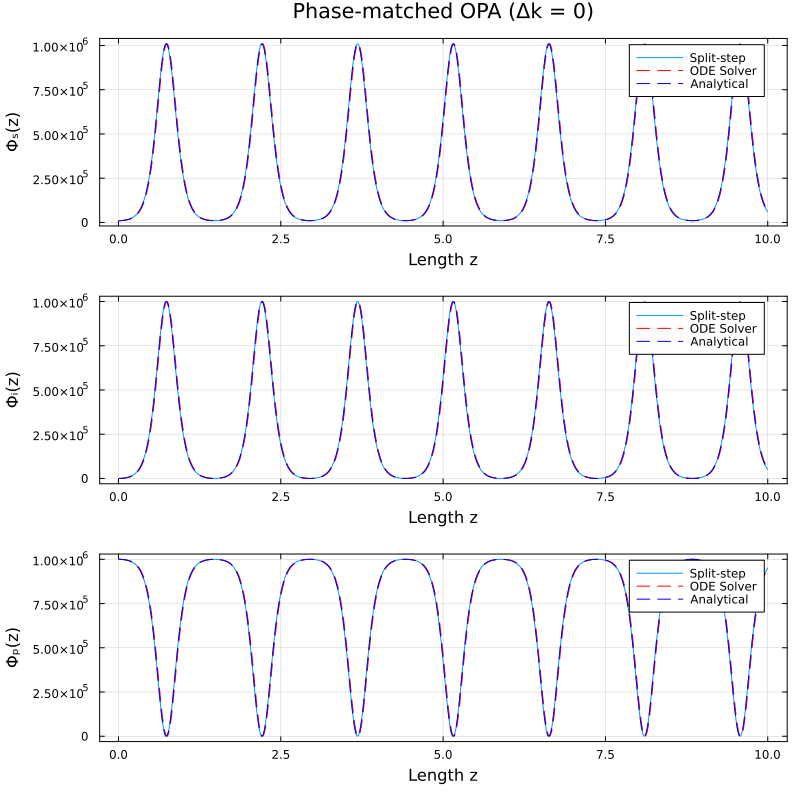

In [21]:
# Light propagation under OPA
# Phaes-matched OPA-CW
arr_zpos = collect(const_opa_0.dz:const_opa_0.dz:linbo3_e_gvd0.prop.ll)

# ODE Solution
test_opa_sol = opa_cw_ode(arr_zpos, 0, const_opa_0);

# Analytic Solution: Jacobi elliptic
test_opa_intensity = [opa_cw_intensity(z, 0.0, const_opa_0) for z in arr_zpos]
test_opa_intensity = hcat(test_opa_intensity...);

# PLOT OPA INTENSITY
opa0_signal = plot(arr_zpos, abs.(const_opa_0.out_amp[1,1,:]).^2, 
    frame=:box, xlabel = "Length z", ylabel = "Φₛ(z)", 
    label="Split-step", legend=:topright, title = "Phase-matched OPA (Δk = 0)")

plot!(opa0_signal, arr_zpos, abs.(test_opa_sol["flux"][1,:]), color=:red, linestyle=:dash, label = "ODE Solver")
plot!(opa0_signal, arr_zpos, abs.(test_opa_intensity[1,:]), color=:blue, linestyle=:dash, label = "Analytical")

opa0_idler = plot(arr_zpos, abs.(const_opa_0.out_amp[1,2,:]).^2, label="Split-step",
    xlabel = "Length z", ylabel = "Φᵢ(z)", frame=:box, legend=:topright)
plot!(opa0_idler, arr_zpos, abs.(test_opa_sol["flux"][2,:]), color=:red, linestyle=:dash, label = "ODE Solver")
plot!(opa0_idler, arr_zpos, abs.(test_opa_intensity[2,:]), color=:blue, linestyle=:dash, label = "Analytical")

opa0_pump = plot(arr_zpos, abs.(const_opa_0.out_amp[1,3,:]).^2, label="Split-step",
    xlabel = "Length z", ylabel = "Φₚ(z)", frame=:box, legend=:topright)
plot!(opa0_pump, arr_zpos, abs.(test_opa_sol["flux"][3,:]), color=:red, linestyle=:dash, label = "ODE Solver")
plot!(opa0_pump, arr_zpos, abs.(test_opa_intensity[3,:]), color=:blue, linestyle=:dash, label = "Analytical")

opa0_plot = plot(opa0_signal, opa0_idler, opa0_pump, layout = (3,1), size = (800,800))

# savefig("figures/test_OPA_dk0.png")
opa0_plot

In [22]:
# Test the function
# The pulsed DOPA properties
const_opa_0 = nl_pulse(linbo3_e_gvd0, cw1; dz = 1e-2, pulse_ref = 1, zero_beta0=true, calculate_dk = true, 
    phase_mismatch = 0.0);

linbo3_e_gvd0.prop.ll = 10.0
arr_zpos = collect(const_opa_0.dz:const_opa_0.dz:linbo3_e_gvd0.prop.ll)

split_step_nl!(linbo3_e_gvd0.prop.ll, const_opa_0, op_nl_chi2!; record_all = true, step_method = rk4_step_nl!,
    with_z = false, p_fft = (p_fft1!, p_ifft1!))

In [23]:
# ODE Solution
test_opa_sol = opa_cw_ode(arr_zpos, 0, const_opa_0);
# Analytic Solution
test_opa_intensity = [opa_cw_intensity(z, 0.0, const_opa_0) for z in arr_zpos]
test_opa_intensity = hcat(test_opa_intensity...);

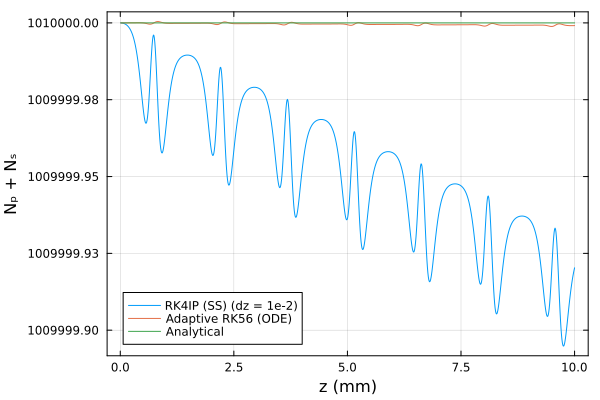

In [24]:
mrowe_plot = plot(xlabel = "z (mm)", ylabel = "Nₚ + Nₛ", frame=:box)
plot!(mrowe_plot, arr_zpos, abs.(const_opa_0.out_amp[1,1,:]).^2 .+ abs.(const_opa_0.out_amp[1,3,:]).^2, 
    label = "RK4IP (SS) (dz = 1e-2)")
plot!(mrowe_plot, arr_zpos, test_opa_sol["flux"][1,:] .+ test_opa_sol["flux"][3,:], label = "Adaptive RK56 (ODE)")
plot!(mrowe_plot, arr_zpos, test_opa_intensity[1,:] .+ test_opa_intensity[3,:], label = "Analytical")
savefig("./figures/manley_rowe_opa_cw.png")

mrowe_plot

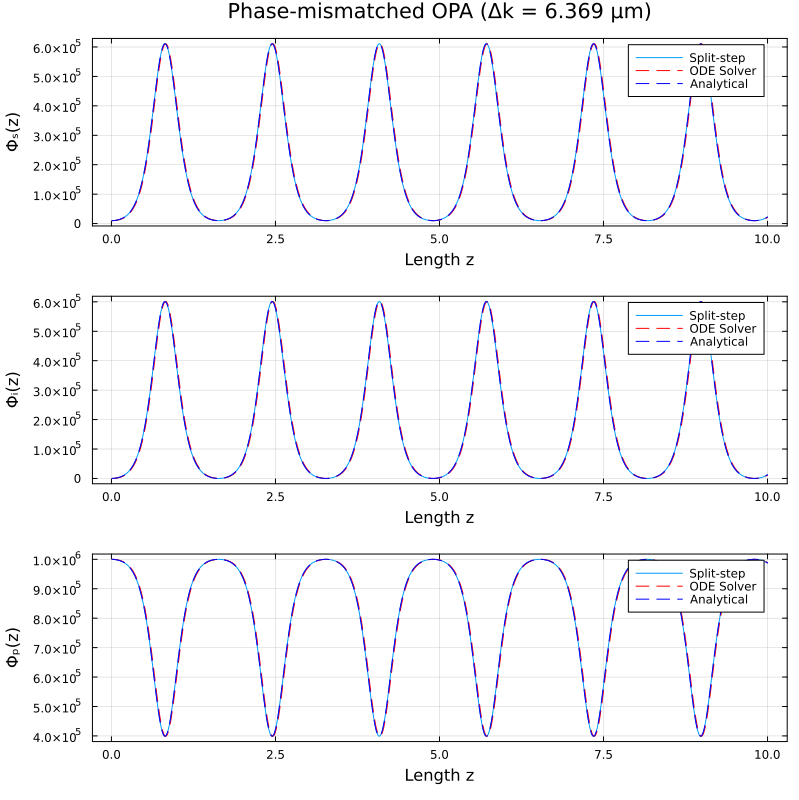

In [25]:
# Phaes-mismatched OPA-CW
arr_zpos = collect(const_opa_mm.dz:const_opa_mm.dz:linbo3_e_gvd0.prop.ll)

# ODE Solution
opa_mm_sol = opa_cw_ode(arr_zpos, const_opa_mm.delta_k, const_opa_mm);
# Analytic Solution
opa_mm_intensity = [opa_cw_intensity(z, const_opa_mm.delta_k, const_opa_mm) for z in arr_zpos]
opa_mm_intensity = hcat(opa_mm_intensity...);

opa_mm_signal = plot(arr_zpos, abs.(const_opa_mm.out_amp[1,1,:]).^2, 
    frame=:box, xlabel = "Length z", ylabel = "Φₛ(z)", 
    label="Split-step", legend=:topright,
    title = "Phase-mismatched OPA (Δk = " * string(round(const_opa_mm.delta_k, digits=3)) * " μm)"

)

# PLOT OPA INTENSITY
plot!(opa_mm_signal, arr_zpos, abs.(opa_mm_sol["flux"][1,:]), color=:red, linestyle=:dash, label = "ODE Solver")
plot!(opa_mm_signal, arr_zpos, abs.(opa_mm_intensity[1,:]), color=:blue, linestyle=:dash, label = "Analytical")

opa_mm_idler = plot(arr_zpos, abs.(const_opa_mm.out_amp[1,2,:]).^2, label="Split-step",
    xlabel = "Length z", ylabel = "Φᵢ(z)", frame=:box, legend=:topright)
plot!(opa_mm_idler, arr_zpos, abs.(opa_mm_sol["flux"][2,:]), color=:red, linestyle=:dash, label = "ODE Solver")
plot!(opa_mm_idler, arr_zpos, abs.(opa_mm_intensity[2,:]), color=:blue, linestyle=:dash, label = "Analytical")

opa_mm_pump = plot(arr_zpos, abs.(const_opa_mm.out_amp[1,3,:]).^2, label="Split-step",
    xlabel = "Length z", ylabel = "Φₚ(z)", frame=:box, legend=:topright)
plot!(opa_mm_pump, arr_zpos, abs.(opa_mm_sol["flux"][3,:]), color=:red, linestyle=:dash, label = "ODE Solver")
plot!(opa_mm_pump, arr_zpos, abs.(opa_mm_intensity[3,:]), color=:blue, linestyle=:dash, label = "Analytical")

opa_mm_plot = plot(opa_mm_signal, opa_mm_idler, opa_mm_pump, layout = (3,1), size = (800,800))
# savefig("figures/test_OPA_dk" * string(round(const_opa_mm.delta_k, digits=3)) * ".png")
opa_mm_plot

### CW OPA with a linearly chirped LN

In [114]:
# Test for CW
omg_ctr_2 = (2*pi*c0*1e-12) ./ [1.55e-6; (1.55 * 1.064 * 1e-6)/(1.55 - 1.064); 1.064e-6;];

delta_beta_0 = (beta_func(linbo3_e_gayer, omg_ctr_2[3]) - beta_func(linbo3_e_gayer, omg_ctr_2[1]) - 
    beta_func(linbo3_e_gayer, omg_ctr_2[2]))
qpm_lambda_0 = 1e3 * 2*pi/ delta_beta_0

cw2 = pars_pulse()
cw2.amp_max = [100.0 ; 0.0; 1.0e3];

lbd_p = 1.064e-6; lbd_s = 1.55e-6;
lbd_i = (lbd_p * lbd_s) / (lbd_s - lbd_p)
cw2.omg_ctr = (2*pi*c0*1e-12) ./ [lbd_s; lbd_i; lbd_p];

cw2.T_pulse = [10.0 ; 10.0 ; 10.0];
cw2.N_div = (2^10);
cw2.f_pulse = Pulse.ff_const;

In [115]:
# Linearly chirped OPA
(zc_t, alpha_t) = (linbo3_e_gayer.prop.ll/2, 1.0)
linbo3_e_gayer.prop.ll = 10.0
linbo3_e_gayer.kappa = 1.0e-3

lin_opa = nl_pulse_adb(linbo3_e_gayer, cw2; dz = 1e-2, pulse_ref = 1, zero_beta0=true, 
    calculate_dk = true, qpm_lambda = qpm_lambda_0, 
    phi_z_func = phi_z_lin, phi_z_pars = (zc_t, alpha_t));
arr_zpos = collect(lin_opa.dz:lin_opa.dz:linbo3_e_gayer.prop.ll)

arr_ωs_z = omg_ctr_2[1] .+ [solve_dω_for_z(z, omg_ctr_2, qpm_lambda_0, linbo3_e_gayer, (zc_t, alpha_t)) for z in arr_zpos];
arr_λs_z = (2*pi*c0*1e-12) ./ (arr_ωs_z) * 1e6;

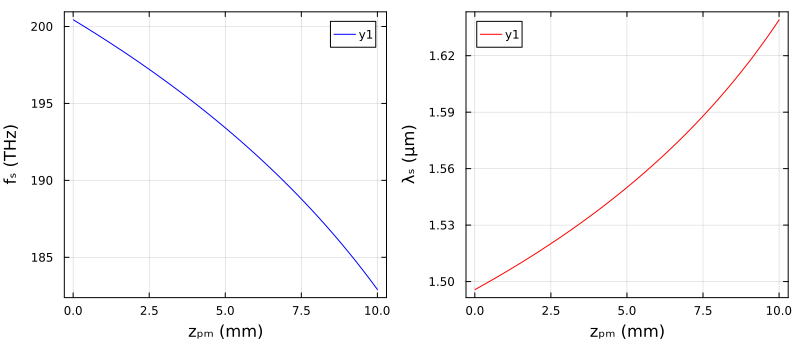

In [116]:
pm_plot_1 = plot(arr_zpos, arr_ωs_z ./ (2*pi), frame=:box, xlabel = "zₚₘ (mm)", ylabel = "fₛ (THz)", color=:blue, 
    leftmargin=3Plots.mm, bottommargin=5Plots.mm)
pm_plot_2 = plot(arr_zpos, arr_λs_z, frame=:box, xlabel = "zₚₘ (mm)", ylabel = "λₛ (μm)", color=:red, leftmargin=3Plots.mm)
plot(pm_plot_1, pm_plot_2, size = (800,350))

In [117]:
split_step_nl!(linbo3_e_gayer.prop.ll, lin_opa, op_nl_adb_chi2!; record_all = true,
    with_z = true, p_fft = (p_fft1!, p_ifft1!))

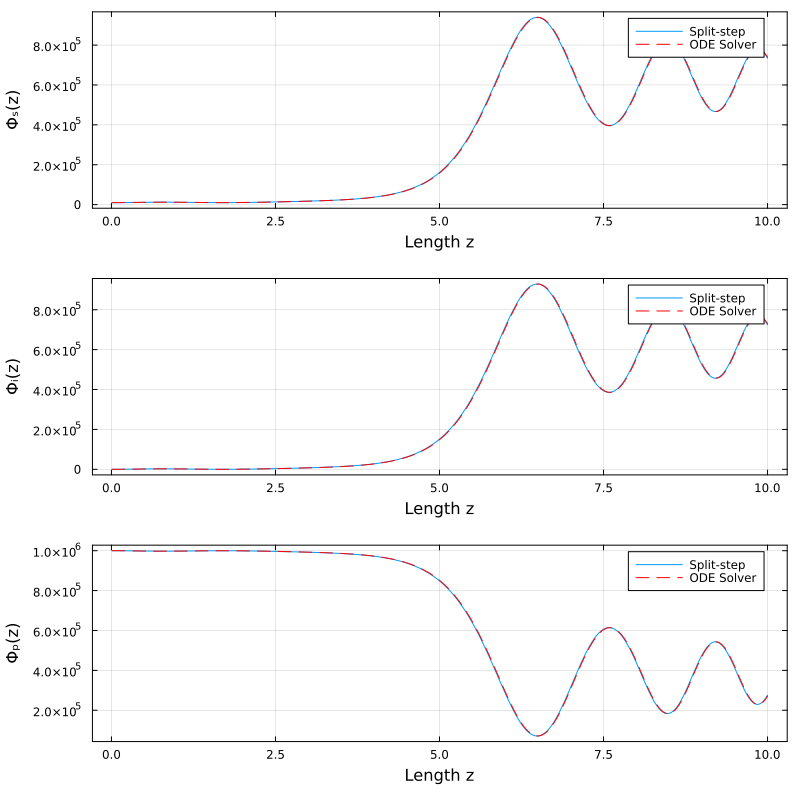

In [118]:
# Phaes-mismatched OPA-CW

# ODE Solution
lin_opa_sol = opa_cw_ode(arr_zpos, lin_opa.delta_k, lin_opa);

# PLOT OPA INTENSITY
lin_opa_signal = plot(arr_zpos, abs.(lin_opa.out_amp[1,1,:]).^2, 
    frame=:box, xlabel = "Length z", ylabel = "Φₛ(z)", 
    label="Split-step", legend=:topright)
plot!(lin_opa_signal, arr_zpos, abs.(lin_opa_sol["flux"][1,:]), color=:red, linestyle=:dash, label = "ODE Solver")

lin_opa_idler = plot(arr_zpos, abs.(lin_opa.out_amp[1,2,:]).^2, label="Split-step",
    xlabel = "Length z", ylabel = "Φᵢ(z)", frame=:box, legend=:topright)
plot!(lin_opa_idler, arr_zpos, abs.(lin_opa_sol["flux"][2,:]), color=:red, linestyle=:dash, label = "ODE Solver")

lin_opa_pump = plot(arr_zpos, abs.(lin_opa.out_amp[1,3,:]).^2, label="Split-step",
    xlabel = "Length z", ylabel = "Φₚ(z)", frame=:box, legend=:topright)
plot!(lin_opa_pump, arr_zpos, abs.(lin_opa_sol["flux"][3,:]), color=:red, linestyle=:dash, label = "ODE Solver")

lin_opa_plot = plot(lin_opa_signal, lin_opa_idler, lin_opa_pump, layout = (3,1), size = (800,800))
# savefig("figures/test_lin_OPA.png")
lin_opa_plot

### Threshold power vs bandwidth

In [227]:
κ_test = 5.0e-3 * sqrt(1e-3) / (10) # mm^-1 ps^1/2
L_wg = 30.0 # mm
loss = 0.75 # 6dB

dk_1_vec = range(0.0, stop=0.25, length=100)
wg_mat_test = lnlt_z;

# Test for CW
(λp, λs) = [1.064e-6, 1.55e-6];
omg_ctr_test = (2*pi*3e8*1e-12) ./ [λs; (λs * λp)/(λs - λp); λp;];
(Ep, Es, Ei) = (hbar*1e12) .* omg_ctr_test

delta_beta_test = (beta_func(wg_mat_test, omg_ctr_test[3]) - beta_func(wg_mat_test, omg_ctr_test[1]) - 
    beta_func(wg_mat_test, omg_ctr_test[2]))
qpm_lambda_test = 1e3 * 2*pi/ delta_beta_test

# Linearly chirped OPA
lnlt_z.prop.ll = L_wg
lnlt_z.kappa = κ_test
(zc_t, dk_1_t) = (lnlt_z.prop.ll/2, 1.0);

In [206]:
solve_bw_lbd_linear(omg_ctr_test, qpm_lambda_test, lnlt_z, (zc_t, 2.5e-1))

Dict{String, Float64} with 6 entries:
  "lbd_1"   => 1.51247
  "omega_2" => 187.749
  "lbd_2"   => 1.59677
  "bw_lbd"  => 0.0843046
  "freq_1"  => 198.214
  "bw_freq" => 10.4651

In [ ]:
solve_bw_lbd_con(omg_ctr_test, qpm_lambda_test, lnlt_z)["bw_lbd"]

In [181]:
dk_1_vec

0.0:0.0025252525252525255:0.25

In [228]:
cth_1 = [cth_cw_opo(loss, κ_test, L_wg) for i in 1:length(dk_1_vec)];
cth_2 = [cth_cw_opo_lin(loss, κ_test, dk) for dk in dk_1_vec];

Pth_1 = abs2.(cth_1) .* (Ep * 1e12);
Pth_2 = abs2.(cth_2) .* (Ep * 1e12);

bw_con = [solve_bw_con(omg_ctr_test, qpm_lambda_test, lnlt_z) for dk in dk_1_vec];
bw_lbd_con = [solve_bw_lbd_con(omg_ctr_test, qpm_lambda_test, lnlt_z)["bw_lbd"] for dk in dk_1_vec];
bw_adb = [solve_bw_linear(omg_ctr_test, qpm_lambda_test, lnlt_z, (zc_t, dk)) for dk in dk_1_vec];
bw_lbd_adb = [solve_bw_lbd_linear(omg_ctr_test, qpm_lambda_test, lnlt_z, (zc_t, dk))["bw_lbd"] for dk in dk_1_vec];

In [199]:
collect(dk_1_vec)

100-element Vector{Float64}:
 0.0
 0.0025252525252525255
 0.005050505050505051
 0.007575757575757576
 0.010101010101010102
 0.012626262626262626
 0.015151515151515152
 0.017676767676767676
 0.020202020202020204
 0.022727272727272728
 0.025252525252525252
 0.027777777777777776
 0.030303030303030304
 ⋮
 0.2222222222222222
 0.22474747474747475
 0.22727272727272727
 0.2297979797979798
 0.23232323232323232
 0.23484848484848486
 0.23737373737373738
 0.2398989898989899
 0.24242424242424243
 0.24494949494949494
 0.2474747474747475
 0.25

In [229]:
δkL(δω) = (beta_func(wg_mat_test, omg_ctr_test[3]) - beta_func(wg_mat_test, omg_ctr_test[1] + δω) - 
    beta_func(wg_mat_test, omg_ctr_test[2] - δω) - 2*pi/(qpm_lambda_test*1e-3) ) * wg_mat_test.prop.ll;

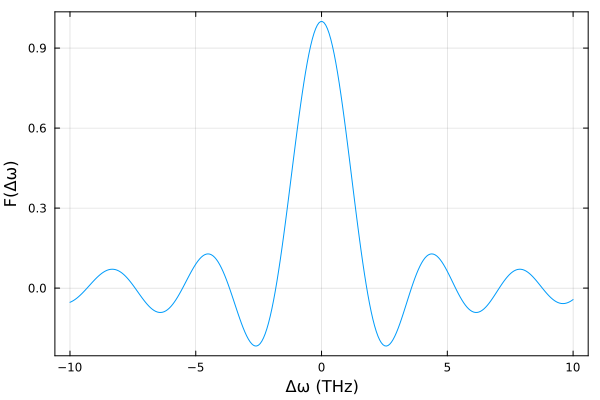

In [230]:
dω_vec = range(-10.0, stop = 10.0, length = 300)
sinc_vec = [sin(0.5*δkL(dω))/(0.5*δkL(dω)) for dω in dω_vec]
plot(dω_vec, sinc_vec, frame=:box, xlabel = "Δω (THz)", ylabel = "F(Δω)", label=nothing)

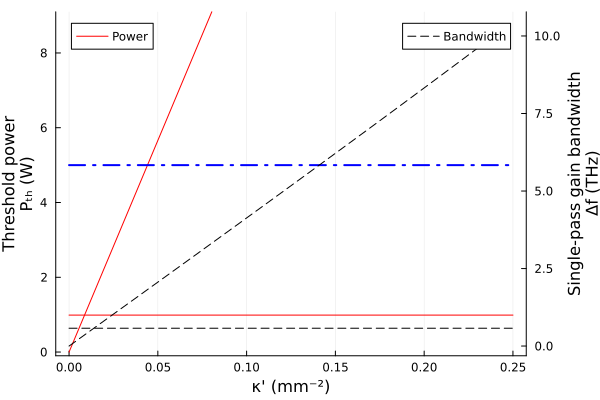

In [231]:
axis2 = plot(frame=:box, xlabel = "κ' (mm⁻²)", legends=:topleft, ylim = (-0.1, 9.1))
plot!(axis2, dk_1_vec, Pth_1, label="Power", ylabel = "Threshold power\nPₜₕ (W)", color=:red)
plot!(axis2, dk_1_vec, Pth_2, label=nothing, color=:red)
plot!(axis2, dk_1_vec, 5. .* ones(length(dk_1_vec)), color=:blue, linestyle=:dashdot, linewidth=2.0, label=nothing)

axis2 = twinx()
plot!(axis2, dk_1_vec, bw_con ./ (2*pi), label="Bandwidth", ylabel = "Single-pass gain bandwidth\nΔf (THz)", 
    color=:black, linestyle=:dash, legends=:topright)
plot!(axis2, dk_1_vec, bw_adb ./ (2*pi), label=nothing, color=:black, linestyle=:dash)

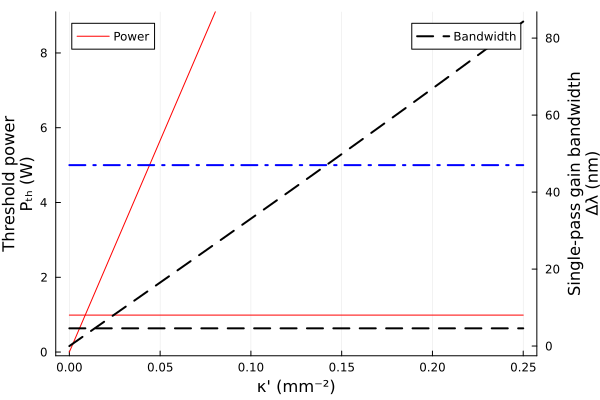

In [232]:
axis1 = plot(frame=:box, xlabel = "κ' (mm⁻²)", legends=:topleft, ylim = (-0.1, 9.1))
plot!(axis1, dk_1_vec, Pth_1, label="Power", ylabel = "Threshold power\nPₜₕ (W)", color=:red)
plot!(axis1, dk_1_vec, Pth_2, label=nothing, color=:red)
plot!(axis1, dk_1_vec, 5.0 .* ones(length(dk_1_vec)), color=:blue, linestyle=:dashdot, linewidth=2.0, label=nothing)

axis1 = twinx()
plot!(axis1, dk_1_vec, bw_lbd_con .* 1e3, label="Bandwidth", ylabel = "Single-pass gain bandwidth\nΔλ (nm)", 
    color=:black, linestyle=:dash, legends=:topright, linewidth = 2.0)
plot!(axis1, dk_1_vec, bw_lbd_adb .* 1e3, label=nothing, color=:black, linestyle=:dash, linewidth = 2.0)

savefig("./figures/Pth_BW_linear_chirp.png")

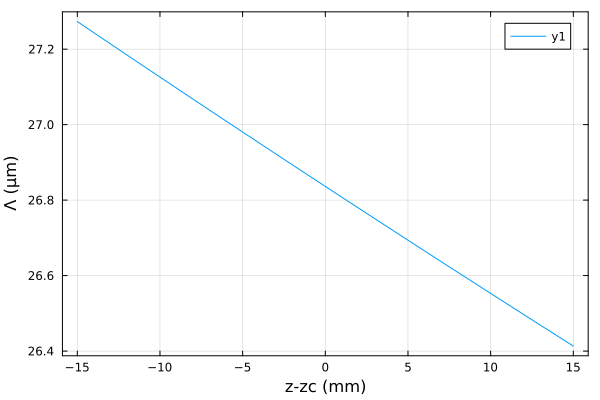

In [72]:
dk_1_val = 0.25
z_vec = range(0.0, stop = wg_mat_test.prop.ll, length = 100) .- wg_mat_test.prop.ll/2
delta_beta_vec = [delta_beta_test .+ dk_1_val .* z for z in z_vec]
lbd_qpm_vec = (2*pi*1e3) ./ delta_beta_vec

plot(z_vec, lbd_qpm_vec, frame=:box, xlabel = "z-zc (mm)", ylabel = "Λ (μm)")

## Benchmarking the split step method

In [130]:
# Simulton: k2"/k1" = 2
dopa1 = pars_nl()
dopa1.βnl = .- [0.0      0.0   ;
                0.0      0.0   ;
                1.75e-3  3.5e-3];
dopa1.ωnl = [0.2 ; 0.4];
dopa1.κnl = 3.93e-2;

# Pulse properties
pulse_sml1 = pars_pulse()

# Specific for simulton
Amax = 1.2
T_sml1 = sqrt(6 * abs(dopa1.βnl[3,1]) / (dopa1.κnl * Amax))

pulse_sml1.amp_max = [Amax ; 0.5 * 1im * Amax];
pulse_sml1.T_pulse = [T_sml1 ; T_sml1];
pulse_sml1.N_div = (2^10);
pulse_sml1.f_pulse = Pulse.ff_sech;

# The pulsed DOPA properties
sml1 = nl_pulse(dopa1, pulse_sml1; fac = 10);

FFTW.set_num_threads(1)
p_fft1! = plan_fft!(sml1.init_amp, 1);
p_ifft1! = plan_ifft!(sml1.init_amp, 1);

Benchmarking the duration & allocation, just for a single core

In [136]:
dz = 0.1
@btime split_step_nl!(dz, sml1, op_nl_dopa!, step_method = naive_step_nl!, p_fft = (p_fft1!, p_ifft1!))
@btime split_step_nl!(dz, sml1, op_nl_dopa!, step_method = rk4_step_nl!, p_fft = (p_fft1!, p_ifft1!))

  86.792 μs (65 allocations: 34.67 KiB)
  397.251 μs (308 allocations: 126.34 KiB)


In [137]:
Lz = 10
@btime split_step_nl!(Lz, sml1, op_nl_dopa!, step_method = naive_step_nl!, p_fft = (p_fft1!, p_ifft1!))
@btime split_step_nl!(Lz, sml1, op_nl_dopa!, step_method = rk4_step_nl!, p_fft = (p_fft1!, p_ifft1!))

  7.515 ms (5214 allocations: 245.89 KiB)
  41.817 ms (29513 allocations: 9.19 MiB)


In [134]:
@profile split_step_nl!(Lz, sml1, op_nl_dopa!, step_method = rk4_step_nl!)

In [135]:
Profile.print(format=:flat)

 Count  Overhead File                    Line Function
 =====  ======== ====                    ==== ========
     1         0 @Base/abstractarray.jl  1245 _getindex
     1         0 @Base/abstractarray.jl  2572 _sub2ind
     1         0 @Base/abstractarray.jl  2588 _sub2ind
     1         0 @Base/abstractarray.jl  2604 _sub2ind_recurse
     1         0 @Base/abstractarray.jl  1251 _to_linear_index
     1         0 @Base/abstractarray.jl  1218 getindex
     1         0 @Base/array.jl           353 fill!
     1         1 @Base/array.jl           903 setindex!
     1         0 @Base/array.jl           520 zeros(::Int64, ::Int64)
     1         0 @Base/array.jl           522 zeros
     1         0 @Base/array.jl           526 zeros
    24         2 @Base/boot.jl            373 eval
     1         0 @Base/broadcast.jl       636 _broadcast_getindex
     4         0 @Base/broadcast.jl       642 _broadcast_getindex
     4         0 @Base/broadcast.jl       643 _broadcast_getindex
     4      

### Tracking allocations line-by-line
Building block: naive_step

In [110]:
function naive_step_test!(dz, dpulse, op_nl; 
                        is_linear = false, p_fft = nothing, cache_id = 1, fft_dim = 1)
    @time temp = @view dpulse.temp_amp[:,:,cache_id]
    @time is_linear ? temp .= zeros(size(temp)...) : op_nl(dz, dpulse; cache_id = cache_id)
    @time dpulse.current_amp .= temp .+ dpulse.current_amp
    @time fw_disp!(dz, dpulse, p_fft = p_fft, fft_dim = fft_dim)
    return
end;

In [71]:
@time op_nl_dopa!(0.1, sml1; cache_id = 2)

  0.000120 seconds (32 allocations: 1.391 KiB)


In [115]:
naive_step_test!(0.2, sml1, op_nl_dopa!, is_linear = false, p_fft = (p_fft1!, p_ifft1!))

  0.000010 seconds (4 allocations: 144 bytes)
  0.000130 seconds (30 allocations: 1.375 KiB)
  0.000041 seconds (2 allocations: 128 bytes)
  0.000284 seconds (14 allocations: 448 bytes)


## Parallel code for split step

### Constructing a vector of objects

In [63]:
# Test case: Different simulton parametrizations
# Simulton: k2"/k1" = 2
dopa1 = pars_nl()
dopa1.βnl = .- [0.0      0.0;      
                0.0      0.0;
                1.75e-3  3.5e-3];
dopa1.ωnl = [0.2 ; 0.4];
dopa1.κnl = 3.93e-2;

In [64]:
len_pulse = 80;
id_thread = zeros(len_pulse)
sml_vec = Array{nl_pulse}(undef, len_pulse)

Abound = 6.0
dAmax = (Abound/len_pulse)
Amax_vec = collect(dAmax:dAmax:Abound)

# === Instantiate multiple objects ===
# In this case, we are just varying the pump/ signal amplitudes
for (i,Amax) in enumerate(Amax_vec)
    pulse_sml = pars_pulse()
    
    # Simulton width
    T_sml = sqrt(6 * abs(dopa1.βnl[3,1]) / (dopa1.κnl * Amax))

    pulse_sml.amp_max = [Amax ; 0.5 * 1im * Amax];
    pulse_sml.T_pulse = [T_sml; T_sml];
    pulse_sml.N_div = (2^10);
    pulse_sml.f_pulse = Pulse.ff_sech;

    sml_vec[i] = nl_pulse(dopa1, pulse_sml; fac = 10);
end

p_fft1! = plan_fft!(sml_vec[1].init_amp, 1);
p_ifft1! = plan_ifft!(sml_vec[1].init_amp, 1);

### Benchmarking FFTW behaviours

Benchmarking FFT behaviours for different nthreads <br>
<b> Resolved </b>: The gain is observed in the larger cases. Multithreading is implemented internally using FFTW library in C

In [ ]:
# It can be faster to simply use single threading for FFTW
Nthmax = 10;
t0vec = zeros(Nthmax)
tpvec = zeros(Nthmax)
for i in collect(1:Nthmax)
    FFTW.set_num_threads(i)
    # FFT
    t0vec[i] = @belapsed fft(sml1.init_amp[1,:])
    
    # Planned FFT
    p_fft1 = plan_fft(sml_vec[1].init_amp[1,:]);
    tpvec[i] = @belapsed p_fft1 * sml1.init_amp[1,:]
end

In [ ]:
plot(t0vec, xlabel = "Number of threads", ylabel = "Time (s)", frame=:box, label="FFTW")
plot!(tpvec, label = "Planned FFTW")

### Calculating multiple cases with multithreading

Check if we can have any gain from using multiple threads <br>
- Seems like we can get ~10x speed up with 40 threads

In [140]:
# Split-step: one instance only, 10 steps
Lz = 1.0;
FFTW.set_num_threads(1);
@btime split_step_nl!(0.1, sml_vec[3], op_nl_dopa!, dz=0.1, step_method = naive_step_nl!, p_fft = (p_fft1, p_ifft1))

  78.334 μs (65 allocations: 34.70 KiB)


In [141]:
@btime split_step_nl!(0.1, sml_vec[3], op_nl_dopa!, dz=0.1, step_method = rk4_step_nl!, p_fft = (p_fft1, p_ifft1))

  384.167 μs (311 allocations: 126.44 KiB)


In [142]:
@btime split_step_nl!(Lz, sml_vec[3], op_nl_dopa!, step_method = rk4_step_nl!, p_fft = (p_fft1, p_ifft1))

  3.866 ms (2963 allocations: 970.59 KiB)


In [143]:
# Using multi-threading
@btime Threads.@threads for i in collect(1:length(sml_vec))
    id_thread[i] = Threads.threadid()
    split_step_nl!(Lz, sml_vec[i], op_nl_dopa!, step_method = rk4_step_nl!, p_fft = (p_fft1, p_ifft1))
end

  20.326 ms (237243 allocations: 75.85 MiB)


In [144]:
# Simply for loops
@btime for i in collect(1:length(sml_vec))
    id_thread[i] = Threads.threadid()
    split_step_nl!(Lz, sml_vec[i], op_nl_dopa!, step_method = rk4_step_nl!, p_fft = (p_fft1, p_ifft1))
end

  350.420 ms (237122 allocations: 75.83 MiB)


In [146]:
sml_vec[1].arr_time

0.03686360311437002

### Trying CUDA
I definitely see a speed up using CUDA

In [72]:
# sml_vec is the list of dopa parameters
sml_cuda = nl_pulse_p(sml_vec);

In [74]:
size(sml_cuda.init_amp_p)

(1024, 80, 2)

In [8]:
L = 0.1
p_fft_cuda! = plan_fft!(sml_cuda.current_amp_p, 1)
p_ifft_cuda! = plan_ifft!(sml_cuda.current_amp_p, 1)
split_step_p!(L, sml_cuda, op_nl_dopa!, step_method = rk4_step_p!, p_fft = (p_fft_cuda!, p_ifft_cuda!))

In [68]:
# Using multi-threading
Lz = 10.0
@btime Threads.@threads for i in collect(1:length(sml_vec))
    id_thread[i] = Threads.threadid()
    split_step_nl!(Lz, sml_vec[i], op_nl_dopa!, step_method = rk4_step_nl!, p_fft = (p_fft1!, p_ifft1!))
end

  203.354 ms (2353248 allocations: 735.29 MiB)


In [69]:
@btime split_step_p!(Lz, sml_cuda, op_nl_dopa!, step_method = rk4_step_p!, p_fft = (p_fft_cuda!, p_ifft_cuda!))

  74.152 ms (230886 allocations: 16.38 MiB)


Now testing if the result is indeed accurate <br>
==> Yes, the GPU Code indeed works

In [55]:
Lz = 100.0
sml_cuda = nl_pulse_p(sml_vec);

In [58]:
Lz = 100.0
sml_cuda = nl_pulse_p(sml_vec);
split_step_p!(Lz, sml_cuda, op_nl_dopa!, step_method = rk4_step_p!, p_fft = (p_fft_cuda!, p_ifft_cuda!))
test_amp = Array(sml_cuda.out_amp_p);

In [32]:
Threads.@threads for i in collect(1:length(sml_vec))
    id_thread[i] = Threads.threadid()
    split_step_nl!(Lz, sml_vec[i], op_nl_dopa!, step_method = rk4_step_nl!, p_fft = (p_fft1!, p_ifft1!))
end

In [23]:
# Analytical bencmark
anl_sml_amp = zeros(ComplexF32, size(test_amp)...)
for i in 1:length(sml_vec)
    anl_sml_amp[:,i,:] .= Pulse.simulton_pulse_2(sml_vec[i].arr_time, Lz, Amax_vec[i], sml_vec[i].nl.κnl, sml_vec[i].nl.βnl[3,1]);
end

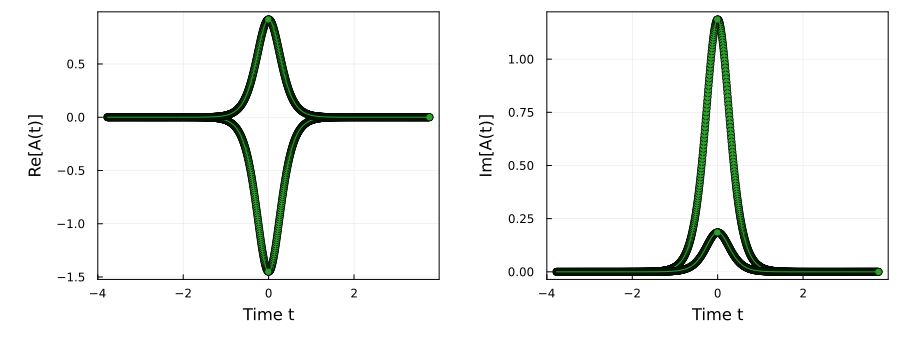

In [67]:
re_sml_plt = plot(frame=:box); im_sml_plt = plot(frame=:box)

# sml_vec[i_sml].out_amp or test_amp[:,i_sml,:]
i_sml = 25
color = palette(:tab20)[mod1(i_sml,20)]
plotCompare(sml_vec[i_sml].arr_time, test_amp[:,i_sml,:], anl_sml_amp[:,i_sml,:], re_sml_plt; 
    color = color, comp = real, margins = 2Plots.mm, legend=nothing, ylabel = "Re[A(t)]")
plotCompare(sml_vec[i_sml].arr_time, test_amp[:,i_sml,:], anl_sml_amp[:,i_sml,:], im_sml_plt; 
    legend=nothing, color = color, margins = 2Plots.mm,
    comp = imag, ylabel = "Im[A(t)]")

plot(re_sml_plt, im_sml_plt, size=(900,350))